## setup env

In [77]:
%%capture
!pip install torch-lr-finder

In [1]:
%load_ext autoreload
%autoreload 2

## External lib
import matplotlib.pyplot as plt
import torch
import sys
import os

from torchvision import transforms
from torch import nn, optim

## Setup working env
PATH_REPO_DRIVE = ''

try:
    import google.colab
    IN_COLAB = True
    PATH_REPO_DRIVE = 'drive/MyDrive/colab/entretien/cat-vs-dog'
except:
    IN_COLAB = False

if IN_COLAB and os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(PATH_REPO_DRIVE)

device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)

Mounted at /content/drive


In [2]:
## Internal lib
from dataset.cat_dog_dataset import CatDogDataloader, plot_images
from model.resnet import ResNet18, ResNet34, ResNet50
from utils.trainer import Trainer

In [3]:
## Download data
%%capture
os.system(f"bash {PATH_REPO_DRIVE}/setup_data.sh")

# dataloader pipeline

In [157]:
NUM_CHANNEL = 3
IMG_SIZE = 256
BATCH_SIZE = 16
UPSCALLING_FACTOR = 1.5

custom_transform = transforms.Compose(
    [
        # transforms.RandomPerspective(distortion_scale=.4, p=.5),
        # transforms.Resize(
        #     (
        #         int(IMG_SIZE*UPSCALLING_FACTOR),
        #         int(IMG_SIZE*UPSCALLING_FACTOR)
        #     )
        # ),
        # transforms.RandomHorizontalFlip(p=.5),
        # transforms.RandomCrop(IMG_SIZE),
        # transforms.RandomRotation(15),
        
        # transforms.ColorJitter(
        #     brightness=.3,
        #     contrast=.3,
        #     saturation=.3,
        #     hue=.2
        # ),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0,0,0), std=(1,1,1))
    ]
)


dataloader = CatDogDataloader(
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    dataset_root = 'cats_and_dogs_filtered',
    custom_transform = custom_transform
)

In [143]:
saving_path = PATH_REPO_DRIVE
saving_path = None

images, _ = iter(dataloader.train_iterator).next()
plot_images(images, 'cat & dog - train', PATH_REPO_DRIVE)

images, _ = iter(dataloader.valid_iterator).next()
plot_images(images, 'cat & dog - valid')

images, _ = iter(dataloader.test_iterator).next()
plot_images(images, 'cat & dog - test', PATH_REPO_DRIVE)

Output hidden; open in https://colab.research.google.com to view.

# model

In [133]:
class Squeeze(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): return x.squeeze()

class Classifier(ResNet18):
    def __init__(self, num_classes=1):
        super(Classifier, self).__init__(num_classes=num_classes)
        
        self.fc = nn.Sequential(
            nn.Linear(512*self.block.expansion, num_classes, bias=True),
            nn.Sigmoid() if num_classes==1 else nn.Softmax(),
            #Lambda(lambda x: x.squeeze())
            Squeeze()
        )

model = Classifier(num_classes=1)

In [72]:
model.summary(device, input_dim=(NUM_CHANNEL,IMG_SIZE,IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
    ResidualBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

# training

In [145]:
## optimizer
#optimizer = optim.SGD
optimizer = optim.Adam

## scheduler
# - cyclic
scheduler = lambda x: optim.lr_scheduler.CyclicLR(x, base_lr=0.01, max_lr=0.1)
scheduler = lambda x: optim.lr_scheduler.StepLR(x, step_size=5, gamma=.5)

In [158]:
trainer = Trainer(
    model=model,
    dataloader=dataloader,
    lr=1e-7,
    criterion=nn.BCELoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    root=''
)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.67E-07


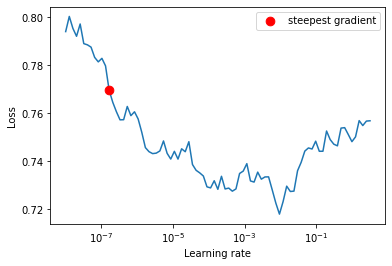

In [160]:
saving_path = None #PATH_REPO_DRIVE

trainer.find_best_lr(end_lr=10, num_iter=100, saving_path=saving_path)

In [74]:
trainer.clean_gpu_memory()

In [75]:
trainer.train_data(num_epochs=300)

Epoch: 0


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.7068 Acc : 54.1482 Time: 78.4202
Valid - Loss : 0.6499 Acc : 62.9808 Time: 2.4721

Epoch: 1


  0%|          | 0/113 [00:00<?, ?it/s]

Test  - Loss : 0.6486 Acc : 63.0952 Time: 11.1782


In [ ]:
title = 'Resnet18 - advanced augmentations #test'
path_to_save = PATH_REPO_DRIVE 
# path_to_save = None

trainer.plot_history(title, path_to_save);

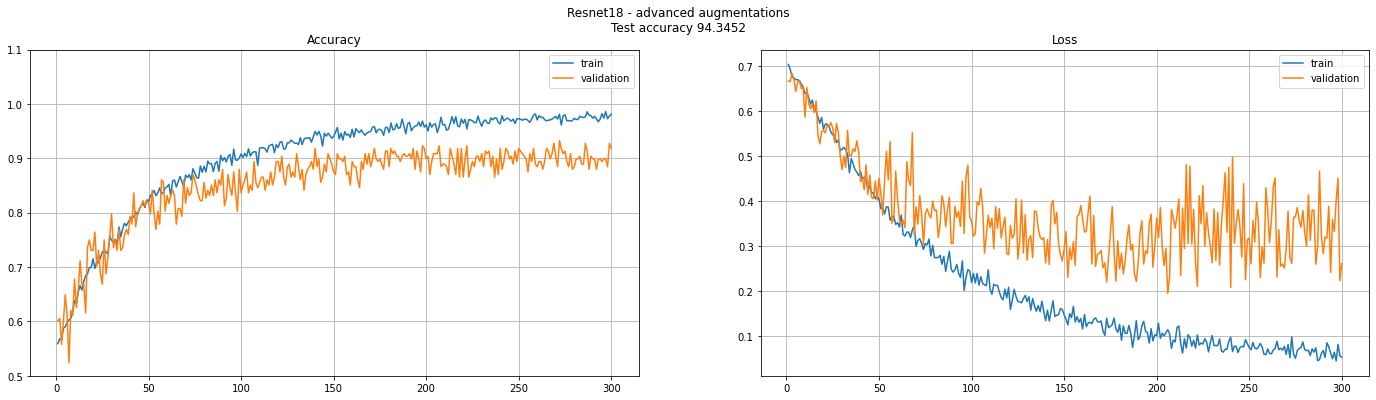

In [80]:
title = 'Resnet18 - advanced augmentations #test'
path_to_save = PATH_REPO_DRIVE 
# path_to_save = None

trainer.plot_history(title, path_to_save);